In [1]:
pip install torchvision 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [2]:
#data transforms
dset_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #data augmentation
    transforms.RandomHorizontalFlip(),    #data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.247, 0.243, 0.261])])

batch_size = 64
#resnet = 'resnet[3,3,3]'
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=dset_transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=dset_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
feature, label = trainset[3]
feature.shape

torch.Size([3, 32, 32])

In [4]:
class BasicBlock(nn.Module):  # two conv as a res block

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)  # conv1 3x3 filter
        self.bn1 = nn.BatchNorm2d(planes)  # batchnorm
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,  # conv2
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)  # batchnorm

        self.shortcut = nn.Sequential()  # skip connection
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 68 
        self.conv1 = nn.Conv2d(3, 68, kernel_size=2,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(68)
        self.layer1 = self._make_layer(block, 68, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 136, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 272, num_blocks[2], stride=2)
        #self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(272, num_classes)
        self.dropout = nn.Dropout(0)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.layer1(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = self.dropout(out)
        out = self.layer3(out)
        out = self.dropout(out)
        #out = self.layer4(out)
        #out = self.dropout(out)
        out = F.avg_pool2d(out,8)
        out = out.view(out.size(0), -1)
        #print(out.shape)
        #out = out.view(-1, 512*2*2)
        out = self.dropout(out)
        out = self.linear(out)
        return out


def project1_model():
    return ResNet(BasicBlock, [3,3,3])  # modify

In [6]:
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet(BasicBlock, [3,3,3]).to(device)
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

In [8]:
print(count_parameters(model))

4883906


In [9]:
epochs = 140
train_save_loss = []
test_save_loss = []
train_save_acc = []
test_save_acc = []
for epoch in range(epochs):
    train_loss = 0.0
    train_corrects = 0.0
    test_loss = 0.0
    test_corrects = 0.0

    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        fit = Loss(outputs, labels)
        fit.backward()
        optimizer.step()

        train_loss += fit.item()
        train_corrects += (torch.eq(torch.max(outputs, 1)[1], labels).sum()).data.cpu().numpy()
    for i, data in enumerate(testloader):
        with torch.no_grad():
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            fit = Loss(outputs, labels)
            test_loss += fit.item()
            test_corrects += (torch.eq(torch.max(outputs, 1)[1], labels).sum()).data.cpu().numpy()

    train_loss = train_loss / len(trainloader)
    test_loss = test_loss / len(testloader)
    train_save_loss.append(train_loss)
    test_save_loss.append(test_loss)
    train_corrects = train_corrects / len(trainloader.dataset)
    train_save_acc.append(train_corrects)
    test_corrects = test_corrects / len(testloader.dataset)
    test_save_acc.append(test_corrects)
    print('Epoch %s, Train loss %s, Test loss %s' % (epoch, train_loss, test_loss))
    print("Accuracy ", test_corrects)

Epoch 0, Train loss 1.4546997434342914, Test loss 1.1277937232309085
Accuracy  0.5915
Epoch 1, Train loss 0.9697476545410693, Test loss 0.8863740271064127
Accuracy  0.6847
Epoch 2, Train loss 0.7760512032700927, Test loss 0.7271787848821871
Accuracy  0.7502
Epoch 3, Train loss 0.6384995113438963, Test loss 0.5981914877511894
Accuracy  0.7928
Epoch 4, Train loss 0.54498966522229, Test loss 0.5569150391847465
Accuracy  0.8087
Epoch 5, Train loss 0.47835423820235234, Test loss 0.5231712340928947
Accuracy  0.8253
Epoch 6, Train loss 0.4292399855449681, Test loss 0.4844585899144981
Accuracy  0.8367
Epoch 7, Train loss 0.39107344328137617, Test loss 0.4197577597324256
Accuracy  0.8553
Epoch 8, Train loss 0.3545526782874866, Test loss 0.423999510088544
Accuracy  0.855
Epoch 9, Train loss 0.3203332851000149, Test loss 0.39340270343859485
Accuracy  0.8673
Epoch 10, Train loss 0.29412450142147595, Test loss 0.3751935107502968
Accuracy  0.874
Epoch 11, Train loss 0.27227082606071557, Test loss 0.

In [20]:
#A = test_save_acc

In [30]:
#NA = test_save_acc

In [40]:
#p3 = test_save_acc

In [47]:
#p4 = test_save_acc

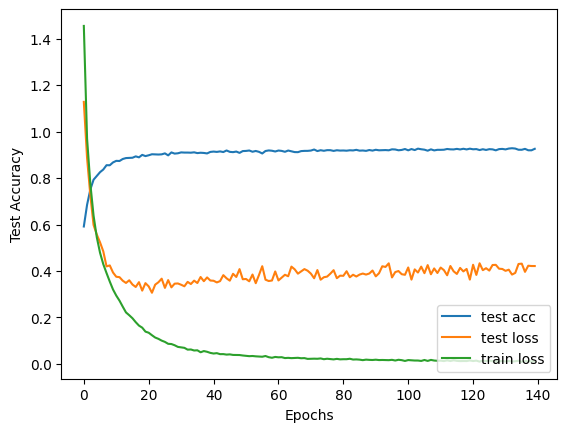

In [10]:
# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt

# %matplotlib inline

fig, plt = plt.subplots()
plt.plot(test_save_acc, label='test acc')
#plt.plot(NA, label='without data augmentation')
#plt.plot(p3, label='p=3')
#plt.plot(p4, label='p=4')
plt.plot(test_save_loss, label='test loss')
plt.plot(train_save_loss, label='train loss')
plt.legend(loc = 'upper right')
#plt.title('Loss and Accuracy for '+resnet)
#plt.savefig(resnet+'.png')
plt.set_xlabel("Epochs")
plt.set_ylabel("Test Accuracy")
torch.save(model.state_dict(), 'project1_model.pt')
